In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Load all sheet names
excel_path = "Customer_Churn_Data_Large.xlsx"
xls = pd.ExcelFile(excel_path)
sheet_names = xls.sheet_names  # List of all sheet names
print("Available sheets:", sheet_names)

# Load each sheet into a dictionary of DataFrames
dataframes = {sheet: xls.parse(sheet) for sheet in sheet_names}

# Access example:
df_main = dataframes['Customer_Demographics']  # Replace with actual sheet name
df_main.head()

Available sheets: ['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [32]:
def show_all_df_info(dataframes):
    for name, df in dataframes.items():
        print(f"\n=== {name} ===")
        print(df.info())
show_all_df_info(dataframes)



=== Customer_Demographics ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB
None

=== Transaction_History ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   int64         
 1   TransactionID    5054 non-null   int64         
 2   TransactionDate  5054 non-null   datetime64[ns]
 3   AmountSpent      5054 non-null   float64       
 4   ProductCategory  5054 non-null   object        
d

## 🔗 Join Strategy Explanation

To build a comprehensive dataset for churn prediction, we need to consolidate customer information from all available sources. Each of the provided sheets contributes a different dimension of behavioral, demographic, or outcome data. Here's the logic behind our join strategy:

### 1. `Customer_Demographics`
This sheet provides static customer attributes such as age, gender, marital status, and income level. It serves as our **primary base table**, as each entry represents a unique customer (`CustomerID`).

### 2. `Transaction_History`
Each customer can have **multiple transactions**, making this a one-to-many relationship. Therefore, we **aggregate** this table by `CustomerID` to extract useful features such as:
- Total amount spent
- Average transaction value
- Number of transactions

### 3. `Customer_Service`
Similar to transaction history, each customer can have **multiple interactions** with customer service. Thus, we also **aggregate** this table, capturing features such as:
- Number of interactions
- Most common resolution type

### 4. `Online_Activity`
This data contains one row per customer, showing their **most recent login**, **login frequency**, and **digital product usage**. It can be **joined directly** on `CustomerID` without aggregation.

### 5. `Churn_Status`
This is our **target variable**, indicating whether the customer has churned. Since it has a one-to-one mapping with `CustomerID`, it can also be **joined directly**.

---

By merging these tables using `CustomerID` as the key, we construct a unified dataset containing demographic, transactional, service, digital behavior, and churn outcome data—ideal for performing EDA and training a predictive model.


In [33]:
# 1. Aggregating Transaction_History
agg_trans = dataframes['Transaction_History'].groupby('CustomerID').agg({
    'AmountSpent': ['sum', 'mean', 'count'],
}).reset_index()
agg_trans.columns = ['CustomerID', 'TotalSpent', 'AvgSpent', 'NumTransactions']

# 2. Aggregating Customer_Service
agg_service = dataframes['Customer_Service'].groupby('CustomerID').agg({
    'InteractionID': 'count',
    'ResolutionStatus': lambda x: x.value_counts().idxmax()  # most common resolution
}).reset_index()
agg_service.columns = ['CustomerID', 'NumInteractions', 'MostCommonResolution']

# 3. Merging all
df_merged = dataframes['Customer_Demographics'] \
    .merge(agg_trans, on='CustomerID', how='left') \
    .merge(agg_service, on='CustomerID', how='left') \
    .merge(dataframes['Online_Activity'], on='CustomerID', how='left') \
    .merge(dataframes['Churn_Status'], on='CustomerID', how='left')


In [34]:
df_merged.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,NumTransactions,NumInteractions,MostCommonResolution,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,416.50,416.50000,1,1.0,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,1547.42,221.06000,7,1.0,Resolved,2023-12-05,5,Website,1
2,3,18,M,Single,Low,1702.98,283.83000,6,1.0,Resolved,2023-11-15,3,Website,0
3,4,21,M,Widowed,Low,917.29,183.45800,5,2.0,Resolved,2023-08-25,2,Website,0
4,5,21,M,Divorced,Medium,2001.49,250.18625,8,NaN,NaN,2023-10-27,41,Website,0


In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            1000 non-null   int64         
 1   Age                   1000 non-null   int64         
 2   Gender                1000 non-null   object        
 3   MaritalStatus         1000 non-null   object        
 4   IncomeLevel           1000 non-null   object        
 5   TotalSpent            1000 non-null   float64       
 6   AvgSpent              1000 non-null   float64       
 7   NumTransactions       1000 non-null   int64         
 8   NumInteractions       668 non-null    float64       
 9   MostCommonResolution  668 non-null    object        
 10  LastLoginDate         1000 non-null   datetime64[ns]
 11  LoginFrequency        1000 non-null   int64         
 12  ServiceUsage          1000 non-null   object        
 13  ChurnStatus        

# Correlation Analysis

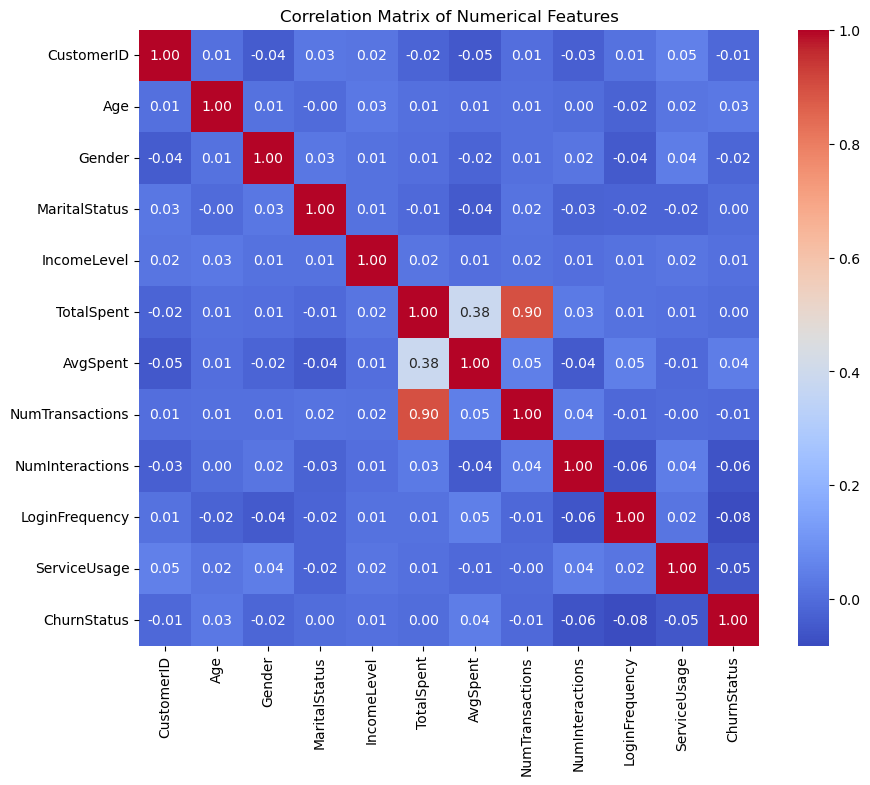

In [36]:
# Copy and convert categorical columns explicitly
df_corr = df_merged.copy()

# Map gender if it's still object dtype
if df_corr['Gender'].dtype == 'object':
    df_corr['Gender'] = df_corr['Gender'].map({'M': 0, 'F': 1})

# Also convert other categorical columns if you'd like to include them
df_corr['ServiceUsage'] = df_corr['ServiceUsage'].astype('category').cat.codes
df_corr['MaritalStatus'] = df_corr['MaritalStatus'].astype('category').cat.codes
df_corr['IncomeLevel'] = df_corr['IncomeLevel'].astype('category').cat.codes

# Then plot again
plt.figure(figsize=(10, 8))
corr_matrix = df_corr.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

C:\Users\Kasandika Andariefli\AppData\Local\Temp\ipykernel_4548\1141302335.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


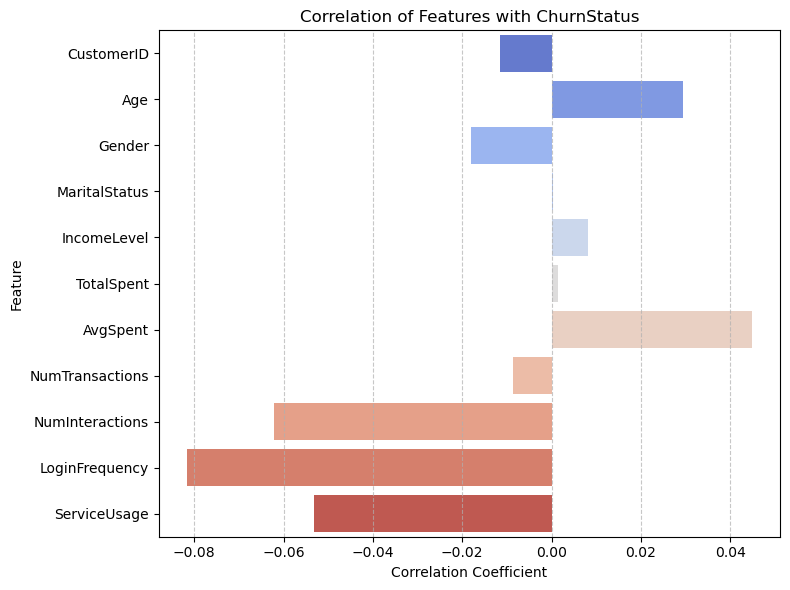

AvgSpent           0.044811
Age                0.029407
IncomeLevel        0.008134
TotalSpent         0.001324
MaritalStatus      0.000270
NumTransactions   -0.008598
CustomerID        -0.011528
Gender            -0.018132
ServiceUsage      -0.053155
NumInteractions   -0.062044
LoginFrequency    -0.081615
Name: ChurnStatus, dtype: float64


In [37]:
# Copy and encode if needed
df_focus = df_merged.copy()
df_focus['Gender'] = df_focus['Gender'].map({'M': 0, 'F': 1})
df_focus['ServiceUsage'] = df_focus['ServiceUsage'].astype('category').cat.codes
df_focus['MaritalStatus'] = df_focus['MaritalStatus'].astype('category').cat.codes
df_focus['IncomeLevel'] = df_focus['IncomeLevel'].astype('category').cat.codes

# Compute correlations
correlations = df_focus.corr(numeric_only=True)['ChurnStatus'].drop('ChurnStatus')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation of Features with ChurnStatus')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Correlation with ChurnStatus (numerical output)
correlations = df_focus.corr(numeric_only=True)['ChurnStatus'].drop('ChurnStatus')
correlations_sorted = correlations.sort_values(ascending=False)
print(correlations_sorted)


## 🎯 Feature Correlation with ChurnStatus (Updated)

This visualization and summary highlight how each feature correlates with the target variable `ChurnStatus`, where a value of **1 represents a churned customer**. Understanding this directionality is key:

- ➕ **Positive correlation** → associated with **higher likelihood of churn**
- ➖ **Negative correlation** → associated with **lower likelihood of churn**


### 📌 Interpretation:

- **LoginFrequency (-0.0816)** shows the strongest inverse correlation with churn, suggesting customers who log in frequently are more likely to **stay**.
- **NumInteractions (-0.0620)** and **ServiceUsage (-0.0532)** follow a similar trend—highlighting that **engagement and support usage reduce churn risk**.
- **Gender (-0.0181)**, now correctly encoded, suggests that **males (0)** may churn slightly more than females (1), though the effect is weak.
- **AvgSpent (+0.0448)** and **Age (+0.0294)** have small positive correlations, hinting that higher spending and older age might slightly increase churn—but this could indicate dissatisfaction or changing needs.
- **TotalSpent**, **IncomeLevel**, and **MaritalStatus** show near-zero correlation and likely require cross-feature interaction analysis for deeper insight.




### 🧠 Takeaway:
The top features negatively correlated with churn relate to **digital behavior and service usage**. These should be prioritized in model design and retention strategies. No single feature is dominant—supporting the use of a multivariate predictive model to capture subtle patterns.


# Anomaly Detection

In [38]:
from scipy.stats import zscore

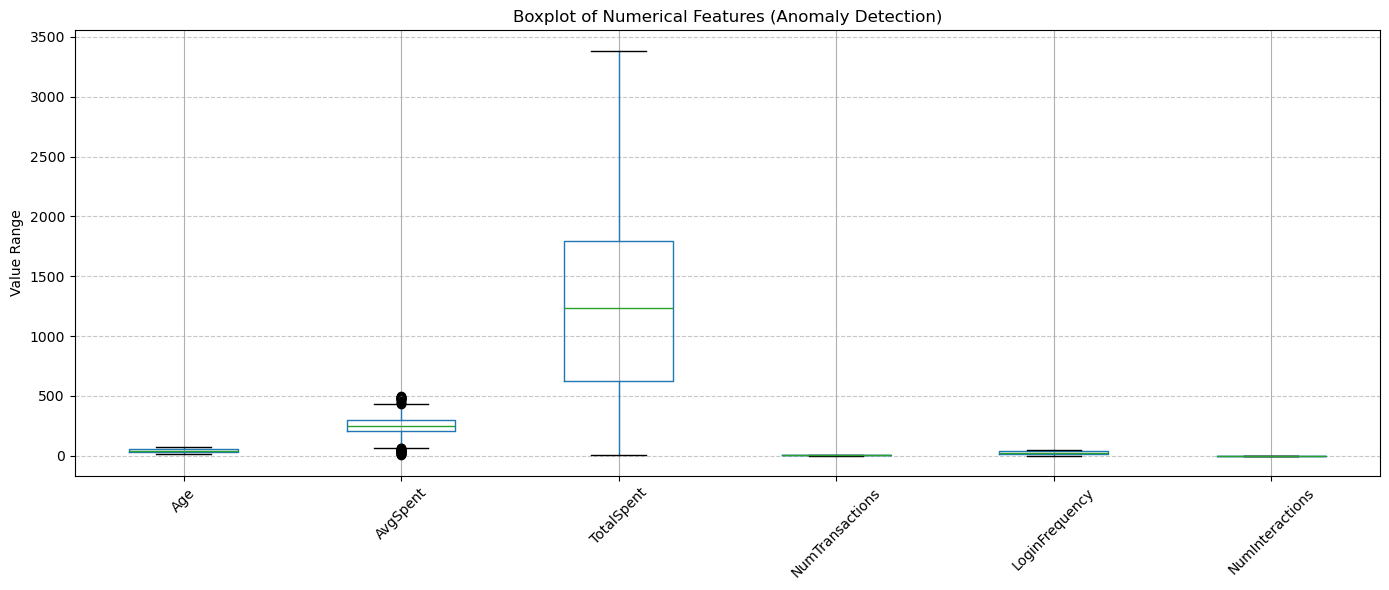

Outliers (|z| > 3) per feature:
Age                0
AvgSpent           6
TotalSpent         0
NumTransactions    0
LoginFrequency     0
NumInteractions    0
dtype: int64


In [39]:
# Select numeric columns (excluding target)
numeric_cols = ['Age', 'AvgSpent', 'TotalSpent', 'NumTransactions', 
                'LoginFrequency', 'NumInteractions']

plt.figure(figsize=(14, 6))
df_merged[numeric_cols].boxplot()
plt.title('Boxplot of Numerical Features (Anomaly Detection)')
plt.ylabel('Value Range')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compute z-scores
z_scores = df_merged[numeric_cols].apply(zscore)

# Count outliers (Z-score > 3 or < -3)
outlier_counts = (z_scores.abs() > 3).sum()
print("Outliers (|z| > 3) per feature:")
print(outlier_counts)

## ⚠️ Anomaly Detection (Z-Score & Boxplot Analysis)
To detect unusual values that may indicate **data quality issues** or **rare behavioral patterns**, we applied **Z-score based anomaly detection** and visualized the results using boxplots.

### 📊 Z-Score Summary:
Only **`AvgSpent`** exhibits significant outliers — 6 customers had unusually high or low average spending patterns.

---

### 📦 Boxplot Insights:
- **AvgSpent** shows clear outliers and a fairly wide spread, suggesting variability in spending behavior. This may capture high-value or low-engagement customer extremes.
- **TotalSpent**, despite its large range, shows no statistical outliers by Z-score — possibly due to its spread being normalized across the population.
- Other features like **Age**, **LoginFrequency**, and **NumTransactions** are tightly distributed with no significant anomalies.

---

### 🧠 Interpretation:
- The outliers in `AvgSpent` should be reviewed carefully:
  - Are they data entry errors?
  - Or do they represent key behavioral patterns (e.g., high-value churn risks)?
- Since no other features show high-anomaly frequency, we **do not recommend removing these outliers at this stage**, but instead flagging them for potential stratified analysis or robust modeling.



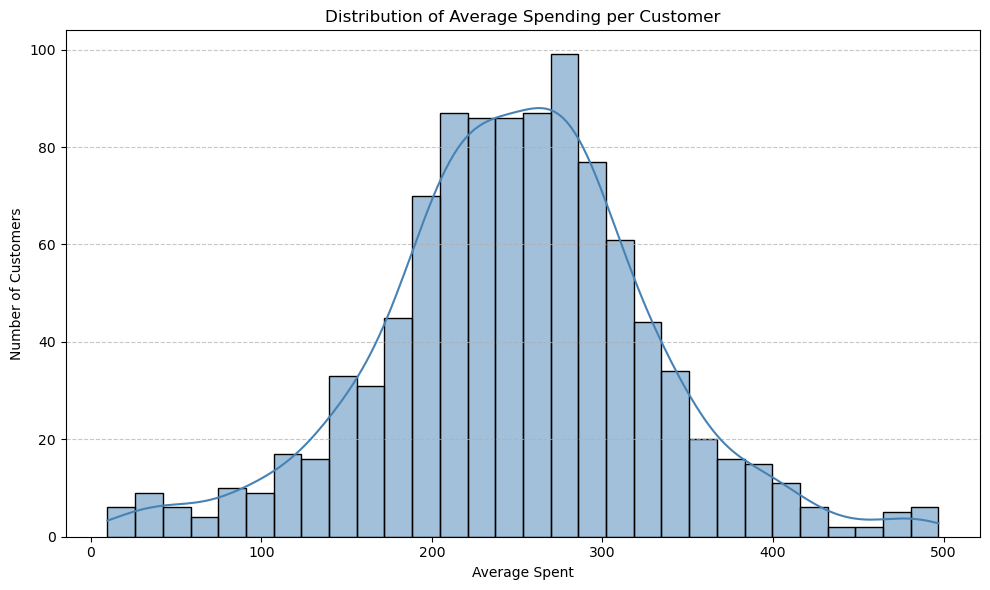

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['AvgSpent'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Average Spending per Customer')
plt.xlabel('Average Spent')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

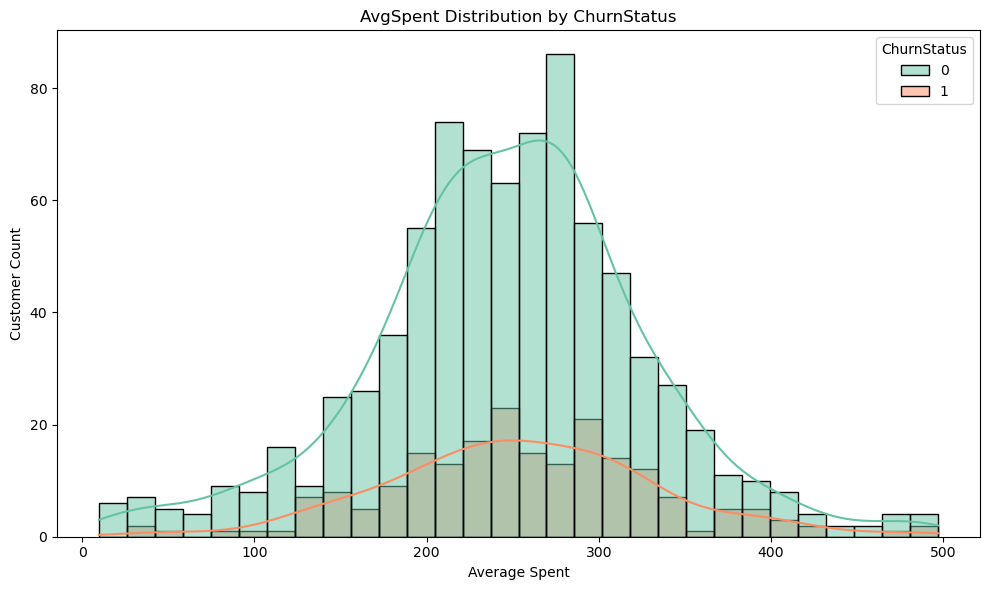

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='AvgSpent', hue='ChurnStatus', bins=30, kde=True, palette='Set2')
plt.title('AvgSpent Distribution by ChurnStatus')
plt.xlabel('Average Spent')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

In [42]:
high_spenders = df_merged[df_merged['AvgSpent'] > df_merged['AvgSpent'].quantile(0.95)]
print("High spenders who churned:")
print(high_spenders[high_spenders['ChurnStatus'] == 1])


High spenders who churned:
     CustomerID  Age Gender MaritalStatus IncomeLevel  TotalSpent    AvgSpent  \
136         137   21      F       Married        High      431.47  431.470000   
143         144   45      F       Married         Low      419.85  419.850000   
236         237   61      M      Divorced         Low      398.99  398.990000   
260         261   27      M       Married         Low      489.07  489.070000   
281         282   42      M        Single        High     2016.68  403.336000   
487         488   28      F       Married      Medium      393.84  393.840000   
497         498   45      F        Single         Low      763.91  381.955000   
509         510   30      M        Single      Medium      392.10  392.100000   
564         565   69      M        Single         Low     2436.25  406.041667   
613         614   64      F       Married        High     1239.16  413.053333   
629         630   61      F       Married      Medium      942.44  471.220000   
8

## 💳 AvgSpent vs. ChurnStatus

The distribution of `AvgSpent` reveals a **slightly right-skewed curve** with a central cluster between \$150–\$300. When split by `ChurnStatus`, both churned and retained customers show similar spread, but a **slightly higher proportion of churners exists in the upper-middle spend range**.

### 🧠 Insight:
- High spend does **not guarantee loyalty**. A subset of churners are high spenders, potentially indicating dissatisfaction or lack of personalization despite high engagement.
- This segment should be considered for **targeted retention strategies**, such as loyalty rewards, concierge support, or exclusive financial products.